## Final Testing Images

In [1]:
! git clone https://github.com/biplav-s/image-mask-estimate

Cloning into 'image-mask-estimate'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 1), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


## Classification Dataset

Train set

In [2]:
!gdown --id 1nmLc8_Xgj7jFBffjKqsMXYXWZpiTzgut
!unzip /content/Dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: Dataset/with_mask/Augmented_174_8862116.png  
 extracting: Dataset/with_mask/Augmented_174_936727.png  
 extracting: Dataset/with_mask/Augmented_175_1905603.png  
 extracting: Dataset/with_mask/Augmented_175_5746201.png  
 extracting: Dataset/with_mask/Augmented_175_7003720.png  
 extracting: Dataset/with_mask/Augmented_175_7535472.png  
  inflating: Dataset/with_mask/Augmented_175_8019231.png  
 extracting: Dataset/with_mask/Augmented_176_1044976.png  
 extracting: Dataset/with_mask/Augmented_176_737534.png  
 extracting: Dataset/with_mask/Augmented_176_7922582.png  
 extracting: Dataset/with_mask/Augmented_176_82258.png  
 extracting: Dataset/with_mask/Augmented_176_8587186.png  
 extracting: Dataset/with_mask/Augmented_176_9809672.png  
 extracting: Dataset/with_mask/Augmented_177_6105722.png  
 extracting: Dataset/with_mask/Augmented_177_6518803.png  
 extracting: Dataset/with_mask/Augmented_177_8071039.png  
 extracti

Test set

In [3]:
!gdown --id 1H3anHpuKHOJBfOU_AUZ4vci9IsCeA8Zp
!unzip /content/CrowdMaskDetection.zip

Downloading...
From: https://drive.google.com/uc?id=1H3anHpuKHOJBfOU_AUZ4vci9IsCeA8Zp
To: /content/CrowdMaskDetection.zip
6.54MB [00:00, 50.8MB/s]
Archive:  /content/CrowdMaskDetection.zip
  inflating: CrowdMaskDetection/images (58).jpeg  
  inflating: CrowdMaskDetection/1-4802484.jpeg  
  inflating: CrowdMaskDetection/AP20058519165315.jpg  
  inflating: CrowdMaskDetection/download (1).jpg  
  inflating: CrowdMaskDetection/images (1).jpg  
  inflating: CrowdMaskDetection/images - 2020-07-15T091156.725.jpeg  
  inflating: CrowdMaskDetection/images - 2020-07-15T091215.363.jpeg  
  inflating: CrowdMaskDetection/images (53).jpeg  
  inflating: CrowdMaskDetection/images (54).jpeg  
  inflating: CrowdMaskDetection/images - 2020-07-15T091159.841.jpeg  
  inflating: CrowdMaskDetection/download (2).jpg  
  inflating: CrowdMaskDetection/download (3).jpg  
  inflating: CrowdMaskDetection/images (57).jpeg  
  inflating: CrowdMaskDetection/images (15).jpeg  
  inflating: CrowdMaskDetection/images (

## Library for face detection

In [4]:
!pip install fdet

## Classification Model

In [5]:
import cv2
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from fdet import io, MTCNN
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from xml.dom.minidom import parse

In [6]:
batch_size = 32
epoch = 2
num_classes = 2
step_per_epoch = len(glob('/content/Dataset/*/*'))//batch_size

image_h, image_w = 128, 128
classes = sorted(['with_mask','without_mask'])

In [7]:
def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/127.5-1
  return img

label_map = {v:i for i, v in enumerate(classes)}

images = glob('/content/Dataset/*/*')
np.random.shuffle(images)

labels = [label_map[x.split('/')[-2]] for x in images]

(train_images, test_images, train_labels, test_labels) = train_test_split(images, labels,
	test_size=0.10, stratify=labels, random_state=42)

#reading image and label
def load_data(image_path, label):
  image = read_img(image_path)
  return image, label

In [8]:
#converting data in tensorflow compatible format
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset
  
train_dataset = data_generator(train_images,train_labels)  

In [9]:
#Classification Model 
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(layer)
model_c = tf.keras.models.Model(base_model.inputs,output)

83689472/83683744 [==============================] - 1s 0us/step


In [10]:
model_c.compile(optimizer=tf.keras.optimizers.Adam(1e-4, decay=1e-4 / epoch),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mask_classification_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model_c.fit(train_dataset,
          batch_size=batch_size,
          epochs=2,steps_per_epoch=step_per_epoch,
          callbacks=callbacks)

Epoch 1/2
504/504 [==============================] - 33s 46ms/step - loss: 0.0699 - accuracy: 0.9744
Epoch 2/2
504/504 [==============================] - 26s 51ms/step - loss: 0.0165 - accuracy: 0.9944


In [11]:
class_map = {
    0: 'With mask',
    1: 'Without mask'
    }
color_map_image = {
    0: [0,1,0],
    1:[1,0,0]
    }

## Visualizing Util

In [12]:
def visualize_detections(image, boxes):
  
  figsize=(7, 7)
  linewidth=1

  image = np.array(image, dtype=np.uint8)

  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)

  ax = plt.gca()

  for box in boxes:
    x, y, w, h = box
  
    face_image = image[y:y+h,x:x+w]
    
    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:

      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1

      _cls = model_c.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)
      
      text = '{}'.format(class_map[_cls[0]])

      patch = plt.Rectangle([x, y], w, h, fill=False, 
                            edgecolor=color_map_image[_cls[0]], linewidth=linewidth)
      ax.add_patch(patch)
      ax.text(x, y, text, bbox={'facecolor':color_map_image[_cls[0]], 'alpha':0.2}, 
          clip_box=ax.clipbox, clip_on=True)

## Face Detection Model and Visualizing image

Downloading: "https://github.com/acnazarejr/fdet/releases/download/weights/mtcnn_pnet.pt" to /root/.cache/torch/hub/checkpoints/mtcnn_pnet.pt


Downloading: "https://github.com/acnazarejr/fdet/releases/download/weights/mtcnn_rnet.pt" to /root/.cache/torch/hub/checkpoints/mtcnn_rnet.pt


Downloading: "https://github.com/acnazarejr/fdet/releases/download/weights/mtcnn_onet.pt" to /root/.cache/torch/hub/checkpoints/mtcnn_onet.pt


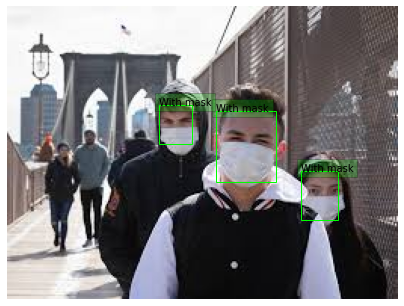

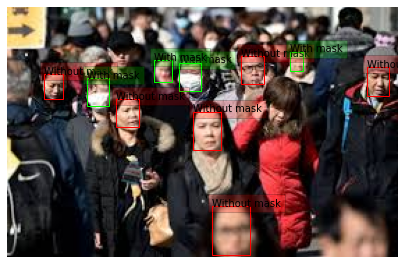

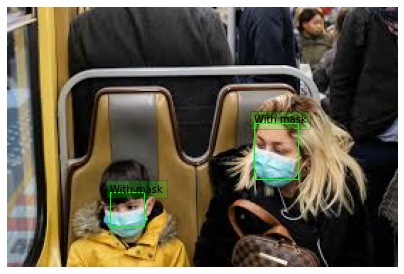

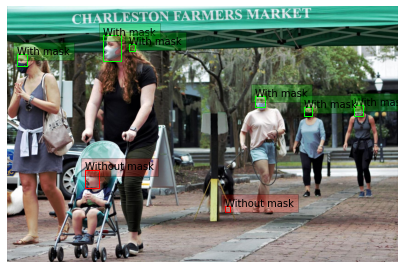

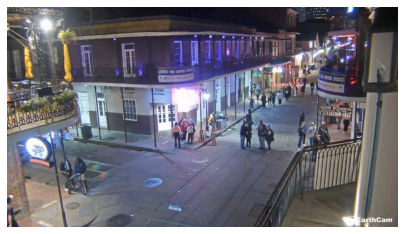

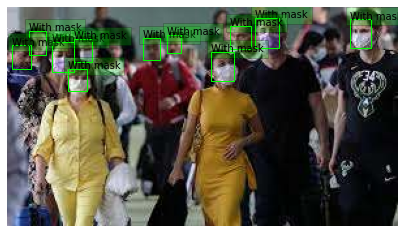

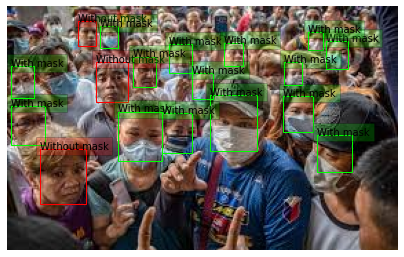

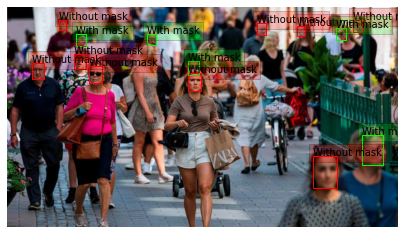

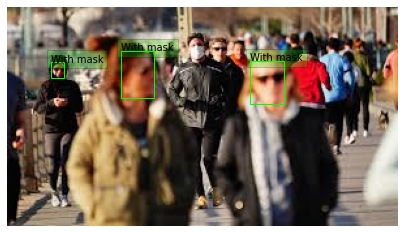

In [ ]:
detector = MTCNN()

image_path = '/content/image-mask-estimate/data/sample-images/*'
for num,i in enumerate(glob(image_path)):
  image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  
  result = detector.detect(image)

  boxes = []
  for i in range(len(result)):
    boxes.append(result[i]['box'])
  boxes = np.array(boxes)

  visualize_detections(image, boxes)

##Downloading Kaggle dataset for Testing

In [12]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshaygupta123","key":"6a983d122ef7035e3a6d882dccc3a87b"}'}

In [13]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection
! mkdir train
! unzip face-mask-detection.zip -d train

 93% 369M/398M [00:06<00:00, 46.5MB/s]
100% 398M/398M [00:06<00:00, 66.6MB/s]
Archive:  face-mask-detection.zip
  inflating: train/annotations/maksssksksss0.xml  
  inflating: train/annotations/maksssksksss1.xml  
  inflating: train/annotations/maksssksksss10.xml  
  inflating: train/annotations/maksssksksss100.xml  
  inflating: train/annotations/maksssksksss101.xml  
  inflating: train/annotations/maksssksksss102.xml  
  inflating: train/annotations/maksssksksss103.xml  
  inflating: train/annotations/maksssksksss104.xml  
  inflating: train/annotations/maksssksksss105.xml  
  inflating: train/annotations/maksssksksss106.xml  
  inflating: train/annotations/maksssksksss107.xml  
  inflating: train/annotations/maksssksksss108.xml  
  inflating: train/annotations/maksssksksss109.xml  
  inflating: train/annotations/maksssksksss11.xml  
  inflating: train/annotations/maksssksksss110.xml  
  inflating: train/annotations/maksssksksss111.xml  
  inflating: train/annotations/maksssksksss112

##Testing Utils

In [14]:
classes = ['with_mask', 'without_mask','mask_weared_incorrect']

In [15]:
image_list = os.listdir('/content/train/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

In [17]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [18]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [19]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax,cls]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box[:4], pred_box[:4])
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

##Testing

In [ ]:
detector = MTCNN(nms_thresholds=(0.6,0.6,0.6))

In [23]:
img_results = {}
for image in test_list:
  gt,pred = [],[]
  gt_mask,pred_mask,gt_nonm,pred_nonm=0,0,0,0
  img = cv2.cvtColor(cv2.imread('/content/train/images/'+image), cv2.COLOR_BGR2RGB)
  img_copy = img.copy()
  img_np = np.array(img_copy, dtype=np.uint8)
  img_path = '/content/train/annotations/'+image[:-4]+'.xml'
  result = detector.detect(img)

  boxes = []
  for i in range(len(result)):
    x,y,w,h = result[i]['box']
    face_image = img_np[y:y+h,x:x+w]
    
    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:

      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1

      _cls = model_c.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)
      if not _cls :
        pred_mask =pred_mask +1
      else:
        pred_nonm =pred_nonm +1
      pred.append([x,y,x+w,y+h,_cls])
  dom = parse(img_path)
  root = dom.documentElement
  objects = root.getElementsByTagName("object")
  for box in objects:
    cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
    x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
    y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
    x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
    y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
    cls_num = classes.index(cls_name) if classes.index(cls_name)!=2 else 0
    if not cls_num:
        gt_mask  =gt_mask +1
    else:
        gt_nonm  =gt_nonm +1
    gt.append([x1, y1, x2, y2,cls_num])
  img_results[image] = get_single_image_results(gt, pred, iou_thr=0.45)
  res_string_1 = f' >Ground_Truth: {gt_mask} people wearing mask and {gt_nonm} people are not wearing mask; Proportion: {gt_mask/(gt_mask+gt_nonm):2.3f}'
  if (pred_mask+pred_nonm)!=0:
    res_string_2 = f' >Prediction: {pred_mask} people wearing mask and {pred_nonm} people are not wearing mask; Proportion: {pred_mask/(pred_mask+pred_nonm):2.3f}'
  else:
    res_string_2 = ' >Prediction: Not identify any People'

  print(f'{image}:') 
  print(res_string_1)
  print(res_string_2)

prec, rec = calc_precision_recall(img_results)
print('')
print(f' >Precision: {prec}; >Recall: {rec}')

maksssksksss511.png:
 >Ground_Truth: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss438.png:
 >Ground_Truth: 4 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss11.png:
 >Ground_Truth: 16 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 15 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss442.png:
 >Ground_Truth: 0 people wearing mask and 1 people are not wearing mask; Proportion: 0.000
 >Prediction: 0 people wearing mask and 1 people are not wearing mask; Proportion: 0.000
maksssksksss182.png:
 >Ground_Truth: 1 people wearing mask and 1 people are not wearing mask; Proportion: 0.500
 >Prediction: 1 people wearing mask and 1 people are not wearing mask; Proportion: 